In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm

import numpy as np
import astropy.units as u
import astropy.io.ascii as at
from astropy.table import Table
from astropy import constants as const
from astropy.coordinates import SkyCoord

# !pip install astroquery
from astroquery.simbad import Simbad
# from astroquery.gaia import Gaia

# Brightest stars

Use Simbad to find the brightest stars in the sky

Converting between B,V and Gaia mags using
https://gea.esac.esa.int/archive/documentation/GEDR3/Data_processing/chap_cu5pho/cu5pho_sec_photSystem/cu5pho_ssec_photRelations.html

Note that I'm not applying the approved limits to conversions of the brightest stars to Gaia, and also these could be Johnsons-Cousins B,V and not Tycho. The conversions are technically for Tycho. Comparisons with the few stars that actually have Gaia G suggests this is reasonable given the scatter in magnitudes anyway

In [ ]:
customSimbad = Simbad()
customSimbad.add_votable_fields("diameter","dim_qual","dim_bibcode","distance",
                               "ids","parallax","ubv","mk","sptype",
                               "flux(B)","flux_qual(B)",
                               "flux(V)","flux_qual(V)",
                               "flux(G)","flux_qual(G)")

In [ ]:
result = customSimbad.query_criteria("vmag<2.5",otype="*")

In [ ]:
result.dtype

dtype([('MAIN_ID', 'O'), ('RA', '<U13'), ('DEC', '<U13'), ('RA_PREC', '<i2'), ('DEC_PREC', '<i2'), ('COO_ERR_MAJA', '<f4'), ('COO_ERR_MINA', '<f4'), ('COO_ERR_ANGLE', '<i2'), ('COO_QUAL', '<U1'), ('COO_WAVELENGTH', '<U1'), ('COO_BIBCODE', 'O'), ('Diameter_diameter', '<f8'), ('Diameter_Q', '<U1'), ('Diameter_unit', '<U4'), ('Diameter_error', '<f8'), ('Diameter_filter', '<U8'), ('Diameter_method', '<U8'), ('Diameter_bibcode', '<U19'), ('GALDIM_QUAL', '<U1'), ('GALDIM_BIBCODE', 'O'), ('Distance_distance', '<f8'), ('Distance_Q', '<U1'), ('Distance_unit', '<U4'), ('Distance_merr', '<f8'), ('Distance_perr', '<f8'), ('Distance_method', '<U8'), ('Distance_bibcode', '<U19'), ('IDS', 'O'), ('PLX_VALUE', '<f8'), ('PLX_PREC', '<i2'), ('PLX_ERROR', '<f4'), ('PLX_QUAL', '<U1'), ('PLX_BIBCODE', 'O'), ('MK_ds', '<U2'), ('MK_mss', '<U3'), ('MK_Spectral_type', 'O'), ('MK_bibcode', '<U19'), ('SP_TYPE', 'O'), ('SP_QUAL', '<U1'), ('SP_BIBCODE', 'O'), ('FLUX_B', '<f4'), ('FLUX_QUAL_B', '<U1'), ('FLUX_V', '<

In [ ]:
# Even though distances are measured, more stars have just a parallax value
parallax_as = result["PLX_VALUE"]/1000
distance = 1/parallax_as
dmod = 5*np.log10(distance)-5
bmv = result["FLUX_B"]-result["FLUX_V"]
M_B = result["FLUX_B"] - dmod
M_V = result["FLUX_V"] - dmod

In [ ]:
bsort = np.argsort(result["FLUX_V"])
bright_25 = bsort[:25]

In [ ]:
has_gaia = np.where(result["FLUX_G"].mask==False)[0]

In [ ]:
def calc_gcolor(bmv):
    return 0.02621 + 1.458*bmv -0.6176*bmv**2 + 0.1817*bmv**3

In [ ]:
def calc_bv(bp_rp):
    GmV = -0.01077 -0.0682*bp_rp -0.2387*bp_rp**2 + 0.02342*bp_rp**3
    GmB = -0.004288 -0.8547*bp_rp +0.1244*bp_rp**2 - 0.9085*bp_rp**3 + 0.4843*bp_rp**4 -0.06814*bp_rp**5
    BmV = -1*GmB + GmV
    return BmV

In [ ]:
def calc_g_bmv(v,bmv):
    GmV = -0.01072 -0.2870*bmv +0.05807*bmv**2 -0.06791*bmv**3
    g = GmV+v
    return g

In [ ]:
bright_bp_rp = calc_gcolor(bmv)

In [ ]:
bright_calcg = calc_g_bmv(result["FLUX_V"],bmv)

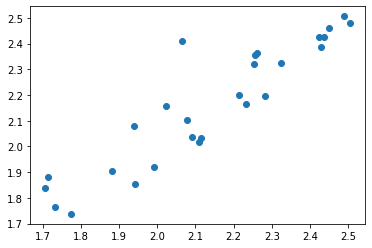

In [ ]:
plt.plot(result["FLUX_G"][has_gaia],bright_calcg[has_gaia],'o')

In [ ]:
bright_M_G = bright_calcg - dmod
bright_M_G[has_gaia] = result["FLUX_G"][has_gaia] - dmod[has_gaia]

Text(0, 0.5, 'M_B')

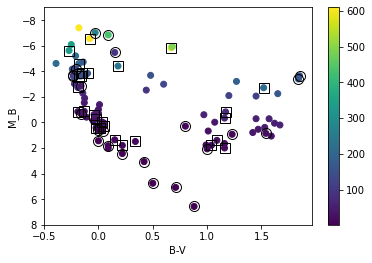

In [ ]:
# plt.plot(bmv,M_B,'o')
plt.scatter(bmv,M_B,c=distance)
plt.plot(bmv[bright_25],M_B[bright_25],'ko',mfc="none",ms=10)
plt.plot(bmv[has_gaia],M_B[has_gaia],'ks',mfc="none",ms=10)
plt.colorbar()
plt.ylim(8,-9)
plt.xlabel("B-V")
plt.ylabel("M_B")

# Nearest stars

retrieve the nearest stars to the Sun from Gaia


In [ ]:
def gaia_to_v(g,bp_rp):
  GmV = -0.01077 -0.0682*bp_rp -0.2387*bp_rp**2 + 0.02342*bp_rp**3
  v = g - GmV
  v[(bp_rp<-0.35) | (bp_rp>4.0)] = np.nan
  return v

In [ ]:
def gaia_to_b(g,bp_rp):
  GmB = -0.004288 -0.8547*bp_rp +0.1244*bp_rp**2 - 0.9085*bp_rp**3 + 0.4843*bp_rp**4 -0.06814*bp_rp**5
  b = g - GmB
  b[(bp_rp<-0.3) | (bp_rp>3.0)] = np.nan
  return b

In [ ]:
near = at.read("GaiaEDR3_GCNS_10pc.tsv",delimiter="|",data_start=3)
near.dtype

dtype([('RA_ICRS', '<f8'), ('DE_ICRS', '<f8'), ('Plx', '<f8'), ('Gmag', '<f8'), ('BPmag', '<f8'), ('RPmag', '<f8')])

In [ ]:
near_g = near["Gmag"]
near_bp_rp = near["BPmag"]-near["RPmag"]
near_b = gaia_to_b(near_g,near_bp_rp)
near_v = gaia_to_v(near_g,near_bp_rp)
near_bmv = near_b-near_v
near_bmv[(near_bp_rp<-0.3) | (near_bp_rp>3)] = np.nan

In [ ]:
near_plx_as = near["Plx"]/1000
near_dist = 1/near_plx_as
near_dmod = 5*np.log10(near_dist)-5
near_M_B = near_b - near_dmod
near_M_V = near_v - near_dmod
near_M_G = near["Gmag"] - near_dmod

Text(0, 0.5, 'M_V')

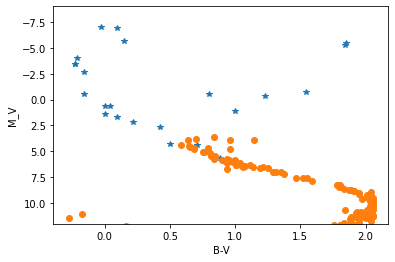

In [ ]:
plt.plot(bmv[bright_25],M_V[bright_25],'*')

plt.plot(near_bmv,near_M_V,'o')

plt.ylim(12,-9)
plt.xlabel("B-V")
plt.ylabel("M_V")

Text(0.5, 0, 'BP-RP')

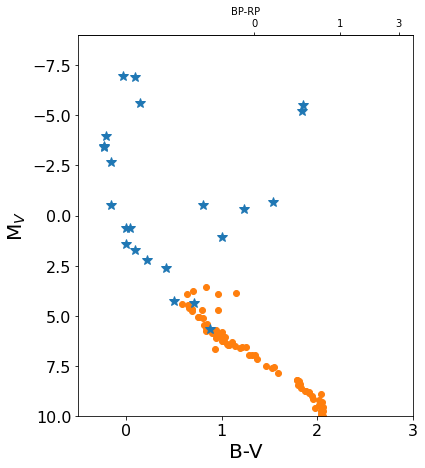

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,7))
ax1.plot(bmv[bright_25],M_V[bright_25],'*',ms=10)
ax1.plot(near_bmv,near_M_V,'o',zorder=-5)
ax1.set_ylim(10,-9)
ax1.set_xlim(-0.5,3)
ax1.set_xlabel("B-V",fontsize=20)
ax1.set_ylabel(r"M$_V$",fontsize=20)
# plt.text(2,-2,"Brightest stars",color="C0",fontsize=20)
# plt.text(2,5,"Closest stars",color="C1",fontsize=20)
ax1.tick_params(labelsize=16)
# plt.savefig("BV_CMD_Near_Bright.png",bbox_inches="tight",dpi=600)

# ax2 = ax1.secondary_xaxis('top', functions=(calc_gcolor,calc_bv))
# ax2.set_xlabel("BP-RP")

In [ ]:
print(calc_gcolor(2.5))

2.6502724999999994


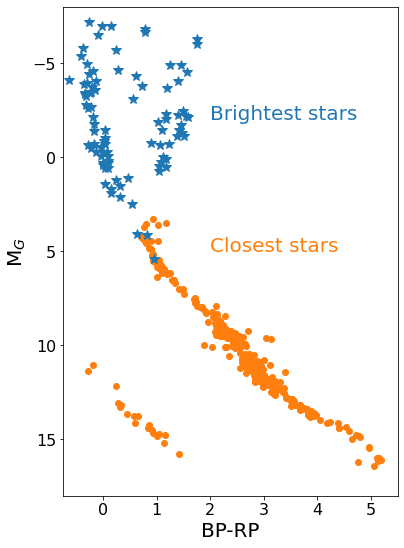

In [ ]:
plt.figure(figsize=(6,9))
plt.plot(bright_bp_rp,bright_M_G,'*',ms=10)
plt.plot(near_bp_rp,near_M_G,'o',zorder=-5)
plt.ylim(18,-8)
plt.xlim(-0.75,5.5)
plt.xlabel("BP-RP",fontsize=20)
plt.ylabel(r"M$_G$",fontsize=20)
plt.text(2,-2,"Brightest stars",color="C0",fontsize=20)
plt.text(2,5,"Closest stars",color="C1",fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=16)
ax.set_xticks(np.arange(6))
plt.savefig("Gaia_CMD_Near_Bright.png",bbox_inches="tight",dpi=600)

# Write out tables as needed

Need a table of bright stars for students

In [ ]:
result.dtype

dtype([('MAIN_ID', 'O'), ('RA', '<U13'), ('DEC', '<U13'), ('RA_PREC', '<i2'), ('DEC_PREC', '<i2'), ('COO_ERR_MAJA', '<f4'), ('COO_ERR_MINA', '<f4'), ('COO_ERR_ANGLE', '<i2'), ('COO_QUAL', '<U1'), ('COO_WAVELENGTH', '<U1'), ('COO_BIBCODE', 'O'), ('Diameter_diameter', '<f8'), ('Diameter_Q', '<U1'), ('Diameter_unit', '<U4'), ('Diameter_error', '<f8'), ('Diameter_filter', '<U8'), ('Diameter_method', '<U8'), ('Diameter_bibcode', '<U19'), ('GALDIM_QUAL', '<U1'), ('GALDIM_BIBCODE', 'O'), ('Distance_distance', '<f8'), ('Distance_Q', '<U1'), ('Distance_unit', '<U4'), ('Distance_merr', '<f8'), ('Distance_perr', '<f8'), ('Distance_method', '<U8'), ('Distance_bibcode', '<U19'), ('IDS', 'O'), ('PLX_VALUE', '<f8'), ('PLX_PREC', '<i2'), ('PLX_ERROR', '<f4'), ('PLX_QUAL', '<U1'), ('PLX_BIBCODE', 'O'), ('MK_ds', '<U2'), ('MK_mss', '<U3'), ('MK_Spectral_type', 'O'), ('MK_bibcode', '<U19'), ('SP_TYPE', 'O'), ('SP_QUAL', '<U1'), ('SP_BIBCODE', 'O'), ('FLUX_B', '<f4'), ('FLUX_QUAL_B', '<U1'), ('FLUX_V', '<

In [ ]:
tab = result["MAIN_ID","RA","DEC","PLX_VALUE","FLUX_B","FLUX_V","FLUX_G"]
tab.rename_column("FLUX_G","Gmag")
tab.rename_column("FLUX_B","Bmag")
tab.rename_column("FLUX_V","Vmag")
tab.rename_column("PLX_VALUE","Parallax(mas)")
# tab["Distance(pc)"] = distance

In [ ]:
need_g = tab["Gmag"].mask==True
tab["Gmag"][need_g] = bright_calcg[need_g]
tab["Gmag"][need_g].mask = False
tab["BP-RP"] = bright_bp_rp

In [ ]:
tab.sort("Vmag")

In [ ]:
tab

MAIN_ID,RA,DEC,Parallax(mas),Bmag,Vmag,Gmag,BP-RP
,"""h:m:s""","""d:m:s""",mas,mag,mag,mag,
object,str13,str13,float64,float32,float32,float32,float32
* alf CMa,06 45 08.9172,-16 42 58.017,379.210,-1.46,-1.46,-1.47072,0.02621
* alf Car,06 23 57.1098,-52 41 44.381,10.550,-0.59,-0.74,-0.79269266,0.23162727
* alf Cen,14 39 29.7199,-60 49 55.999,742.000,0.4,-0.1,-0.24819124,0.6235225
* alf Boo,14 15 39.6720,+19 10 56.673,88.830,1.18,-0.05,-0.45224732,1.2233022
* alf Cen A,14 39 36.4940,-60 50 02.373,743.000,0.72,0.01,-0.19952266,0.8150901
* alf Lyr,18 36 56.3363,+38 47 01.280,130.230,0.03,0.03,0.01928,0.02621
* alf Aur,05 16 41.3587,+45 59 52.769,76.200,0.88,0.08,-0.15792511,0.89037627
* bet Ori,05 14 32.2721,-08 12 05.898,3.780,0.1,0.13,0.1279441,-0.018090734


In [ ]:
tab[:25].write("brightest_25.csv",delimiter=",",overwrite=True)

In [ ]:
tab[:50].write("brightest_50.csv",delimiter=",",overwrite=True)

# HR Diagram

Let's just query the Gaia archive for fundamental parameters of the nearby stars

And then I need bolometric corrections to get luminosity
https://gitlab.oca.eu/ordenovic/gaiadr3_bcg

https://en.wikipedia.org/wiki/Absolute_magnitude#Bolometric_magnitude

In [ ]:
len(near)

286

In [ ]:
print(np.min(near["Plx"]),np.max(near["Plx"]))

100.147 768.067


In [ ]:
gnear = at.read("GaiaDR3_Plxge100_PlxOErrge2.csv",delimiter=",")


In [ ]:
print(gnear.dtype.names)

('solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_sigma5d_max', 'matched_transits', 'new_matched_transits', 

In [ ]:
def calc_Lstar(Mbol):
    L0 = 3.0128e28*u.W
    lstar = L0 * 10**(-0.4*Mbol)
    return lstar

In [ ]:
from bcg import BolometryTable
bc = BolometryTable()

In [ ]:
gnear["BC_G"] = np.ones(len(gnear))*np.nan

for i in range(len(gnear)):
    gnear["BC_G"][i] = bc.main(gnear['teff_gspphot'][i],
                               gnear['logg_gspphot'][i],
                               gnear['mh_gspphot'][i],0.0)

/Volumes/GoogleDrive/My Drive/Teaching/_PHYS108 Stars Galaxies Big Bang/Nearby and Bright Stars/bcg.py:28: UserWarning: Warning: converting a masked element to nan.
  param = np.array([teff,logg,metal,alpha])


In [ ]:
gnear["Mbol"] = gnear["phot_g_mean_mag"] + gnear["BC_G"]
gnear["Lbol"] = calc_Lstar(gnear["Mbol"])

(6500, 2500)

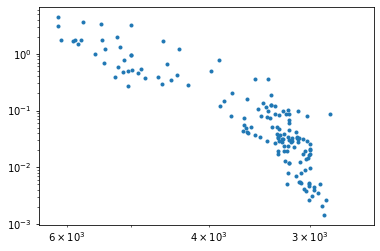

In [ ]:
plt.plot(gnear["teff_gspphot"],gnear["Lbol"]/const.L_sun,'.')
plt.xscale("log")
plt.yscale("log")
plt.xlim(6500,2500)

In [ ]:
gnear["BC_G_rvs"] = np.ones(len(gnear))*np.nan

for i in range(len(gnear)):
    gnear["BC_G_rvs"][i] = bc.main(gnear['rv_template_teff'][i],
                                   gnear['rv_template_logg'][i],
                                   gnear['rv_template_fe_h'][i],0.0)

/Volumes/GoogleDrive/My Drive/Teaching/_PHYS108 Stars Galaxies Big Bang/Nearby and Bright Stars/bcg.py:28: UserWarning: Warning: converting a masked element to nan.
  param = np.array([teff,logg,metal,alpha])


In [ ]:
gnear["Mbol_rvs"] = gnear["phot_g_mean_mag"] + gnear["BC_G_rvs"]
gnear["Lbol_rvs"] = calc_Lstar(gnear["Mbol_rvs"])

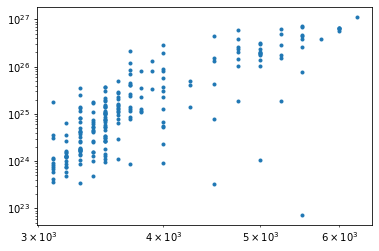

In [ ]:
plt.plot(gnear["rv_template_teff"],gnear["Lbol_rvs"],'.')
plt.xscale("log")
plt.yscale("log")

In [ ]:
distance = 1000/gnear["parallax"]
dmod = 5*np.log10(distance) - 5
MG = gnear["phot_g_mean_mag"] - dmod

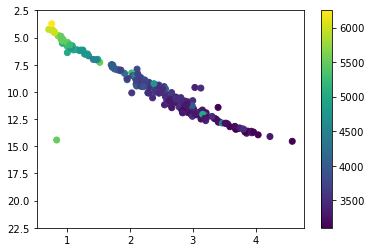

In [ ]:
plt.scatter(gnear["bp_rp"],MG,c=gnear["rv_template_teff"])
plt.ylim(22.5,2.5)
plt.colorbar()

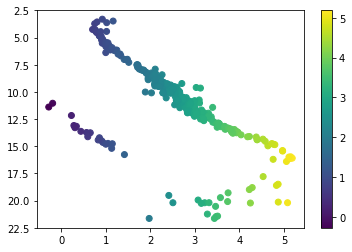

In [ ]:
plt.scatter(gnear["bp_rp"],MG,c=gnear["bp_rp"])
plt.ylim(22.5,2.5)
plt.colorbar()

In [ ]:
bright2 = at.read("brightest_properties.csv")
bright2.dtype

dtype([('System (OpenStax #)', '<i8'), ('Star (sorted by Vmag)', '<i8'), ('Traditional or Official Name', '<U11'), ('Bayer Designation', '<U21'), ('D (ly)', '<f8'), ('SpT', '<U11'), ('Mass (Sun=1)', '<f8'), ('Radius (Sun=1)', '<f8'), ('Luminosity (Sun=1)', '<f8'), ('Teff (K)', '<i8'), ('Bmag', '<f8'), ('Vmag', '<f8')])

(30000, 2500)

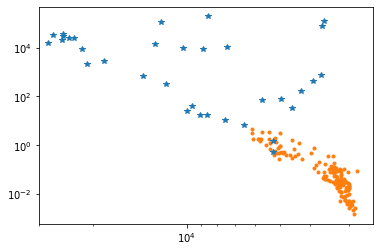

In [ ]:
plt.plot(bright2["Teff (K)"],bright2["Luminosity (Sun=1)"],'*')
plt.plot(gnear["teff_gspphot"],gnear["Lbol"]/const.L_sun,'.',zorder=-5)
plt.xscale("log")
plt.yscale("log")
plt.xlim(30000,2500)